In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy
import inspect
import warnings
import cProfile

from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

import palettable
color_fancy = palettable.wesanderson.Mendl_4.mpl_colors
color_bins = palettable.cartocolors.qualitative.Bold_4_r.mpl_colors

### Learn how to use `astroplan` and `astropy` for observing planning

* [`astroplan` can be found here](https://astroplan.readthedocs.io/en/latest/)

In [3]:
from astroplan import download_IERS_A
download_IERS_A()

In [21]:
import operator

from collections import Sequence 

from astroplan import Observer
from astroplan import FixedTarget
from astroplan.plots import plot_airmass, dark_style_sheet

from pytz import timezone

import astropy.units as u
from astropy.time import Time, TimezoneInfo
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun, get_moon

from matplotlib import dates

In [23]:
# Site
ctio_timezone = timezone('Etc/GMT-4')
ctio = Observer.at_site('CTIO', timezone=ctio_timezone)

# Target
g09 = FixedTarget(name='G09', coord=SkyCoord(133.5, 0.95, unit='deg', frame='icrs'))
g12 = FixedTarget(name='G12', coord=SkyCoord(179.5, 0.00, unit='deg', frame='icrs'))
g15 = FixedTarget(name='G15', coord=SkyCoord(216.5, 0.00, unit='deg', frame='icrs'))
xmm1 = FixedTarget(name='XMM1', coord=SkyCoord(335.0, 2.50, unit='deg', frame='icrs'))
xmm2 = FixedTarget(name='XMM2', coord=SkyCoord(35.0, 2.50, unit='deg', frame='icrs'))

# Planned observing time (UTC)
obs_time = Time('2021-04-01 00:00:00', scale='utc')
obs_day = obs_time + np.linspace(-12, 12, 100) * u.hour

targets = [g09, g12, g15, xmm1, xmm2]
observer = ctio
time = obs_time

In [62]:
observer.moon_illumination(time)

array([0.89596293, 0.89519082, 0.89441624, 0.89363922, 0.89285975,
       0.89207784, 0.89129351, 0.89050675, 0.88971758, 0.888926  ,
       0.88813201, 0.88733563, 0.88653686, 0.88573571, 0.88493219,
       0.88412629, 0.88331804, 0.88250744, 0.88169448, 0.88087919,
       0.88006157, 0.87924162, 0.87841936, 0.87759478, 0.8767679 ,
       0.87593872, 0.87510726, 0.87427351, 0.87343749, 0.8725992 ,
       0.87175865, 0.87091585, 0.8700708 , 0.86922352, 0.868374  ,
       0.86752226, 0.8666683 , 0.86581214, 0.86495377, 0.86409321,
       0.86323046, 0.86236553, 0.86149844, 0.86062917, 0.85975775,
       0.85888418, 0.85800847, 0.85713063, 0.85625065, 0.85536856,
       0.85448436, 0.85359805, 0.85270965, 0.85181915, 0.85092658,
       0.85003193, 0.84913521, 0.84823644, 0.84733561, 0.84643274,
       0.84552784, 0.84462091, 0.84371195, 0.84280099, 0.84188802,
       0.84097305, 0.84005609, 0.83913715, 0.83821624, 0.83729336,
       0.83636852, 0.83544173, 0.834513  , 0.83358233, 0.83264

In [54]:
min_airmass, max_airmass = 0.95, 3.5
timezone = -4

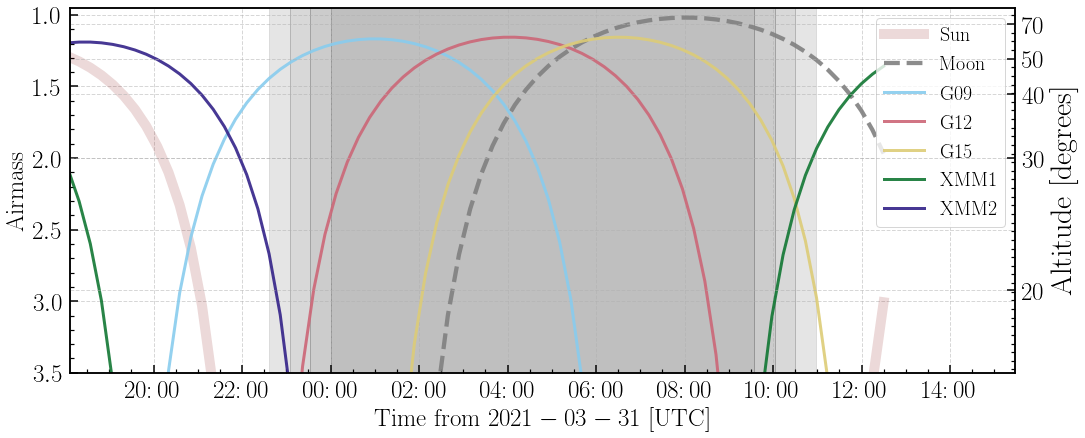

In [72]:
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(left=0.12, right=0.995, bottom=0.15, top=0.995, wspace=0.00, hspace=0.2)

ax = fig.add_subplot(111)
ax.set_prop_cycle('color', palettable.cartocolors.qualitative.Safe_10.mpl_colors)

# Populate time window if needed.
time = Time(time)
if time.isscalar:
    time = time + np.linspace(-12.5, 12.5, 100) * u.hour - timezone * u.hour
elif len(time) == 1:
    warnings.warn('You used a Time array of length 1.  You probably meant '
                  'to use a scalar. (Or maybe a list with length > 1?).')

if not isinstance(targets, Sequence):
    targets = [targets]


# Shade background during night time
start = time[0].datetime

# Calculate and order twilights and set plotting alpha for each
twilights = [
    (observer.sun_set_time(Time(start), which='next').datetime, 0.1),
    (observer.twilight_evening_civil(Time(start), which='next').datetime, 0.2),
    (observer.twilight_evening_nautical(Time(start), which='next').datetime, 0.3),
    (observer.twilight_evening_astronomical(Time(start), which='next').datetime, 0.4),
    (observer.twilight_morning_astronomical(Time(start), which='next').datetime, 0.5),
    (observer.twilight_morning_nautical(Time(start), which='next').datetime, 0.4),
    (observer.twilight_morning_civil(Time(start), which='next').datetime, 0.3),
    (observer.sun_rise_time(Time(start), which='next').datetime, 0.2),
]

twilights.sort(key=operator.itemgetter(0))
for i, twi in enumerate(twilights[1:], 1):
    ax.axvspan(twilights[i - 1][0], twilights[i][0],
               ymin=0, ymax=1, color='grey', alpha=twi[1])

# Plot the Sun
sun_airmass = observer.sun_altaz(time).secz
sun_airmass = np.ma.array(sun_airmass, mask=sun_airmass < 1)
ax.plot_date(time.plot_date, sun_airmass, label=r'$\rm Sun$', fmt='-', 
             linestyle='-', linewidth=10.0, alpha=0.15, color='maroon')

# Plot the Moon
moon_airmass = observer.moon_altaz(time).secz
moon_airmass = np.ma.array(moon_airmass, mask=moon_airmass < 1)
moon_illum = np.mean(observer.moon_illumination(time))
ax.plot_date(time.plot_date, moon_airmass, label=r'$\rm Moon$', fmt='--', 
             linestyle='--', linewidth=5.0 * moon_illum, alpha=0.9, color='grey')

for target in targets:
    # Calculate airmass
    airmass = observer.altaz(time, target).secz
    
    # Mask out nonsense airmasses
    masked_airmass = np.ma.array(airmass, mask=airmass < 1)
    
    # Some checks & info for labels.
    try:
        target_name = target.name
    except AttributeError:
        target_name = ''
        
    ax.plot_date(time.plot_date, masked_airmass, label=r'\rm {:s}'.format(target_name),
                 fmt='-', linestyle='-', linewidth=3.0, alpha=0.9)

ax.legend(loc='upper right', fontsize=20)
    
# Format the time axis
time_0 = (Time(twilights[0][0]) - 4.5 * u.hour).plot_date
time_1 = (Time(twilights[-1][0]) + 4.5 * u.hour).plot_date
ax.set_xlim([time_0, time_1])

date_formatter = dates.DateFormatter(r'$%H\colon%M$')
ax.xaxis.set_major_formatter(date_formatter)

# Invert y-axis and set limits.
y_lim = ax.get_ylim()
if y_lim[1] > y_lim[0]:
    ax.invert_yaxis()
ax.set_ylim([max_airmass, min_airmass])

# Draw lo/hi limit regions, if present
ymax, ymin = ax.get_ylim()       # should be (hi_limit, lo_limit)

# Altitude axis
altitude_ticks = np.array([70, 50, 40, 30, 20, 10])
airmass_ticks = 1. / np.cos(np.radians(90 - altitude_ticks))
ax2 = ax.twinx()
ax2.invert_yaxis()
ax2.set_yticks(airmass_ticks)
ax2.set_yticklabels([r'${:d}$'.format(alt) for alt in altitude_ticks])
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$\rm Altitude\ [degrees]$', fontsize=30)

#ax3 = ax.twiny()
#ax3.xaxis.set_major_formatter(date_formatter)


_ = ax.set_xlabel(r"$\rm Time\ from\ {0}\ [UTC]$".format(min(time).datetime.date()), fontsize=25)
_ = ax.set_ylabel(r"$\rm Airmass$", fontsize=25)